In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.special import softmax
from matplotlib.collections import LineCollection

In [2]:
def make_helices(n_samples=1200, noise=0.05, n_helices=3):
    """Generate 3 intertwined helices."""
    t = np.linspace(np.pi, 4 * np.pi, n_samples // n_helices)
    X = []
    y = []

    for i in range(n_helices):
        theta = t + (i * 2 * np.pi / n_helices)
        x = t * np.cos(theta)
        z = t * np.sin(theta)
        y_coord = t * 0.5  # Stretch along Y

        # Stack and add noise
        helix = np.stack([x, y_coord, z], axis=1)
        helix += np.random.normal(scale=noise, size=helix.shape)

        X.append(helix)
        y.append(np.full(len(t), i))

    return np.vstack(X)[:,[0,2]], np.concatenate(y)

In [3]:
RANDOM_SEED = 42
N = 1200
K = 3
HELIX_NOISE = 0.25

MC_NUM_SAMPLES = 1024*8

MIN_TAU_LOG10 = -3.
MAX_TAU_LOG10 = 2.
NUM_TAU = 50

In [4]:
np.random.seed(RANDOM_SEED)
X, y_true = make_helices(n_samples=N, noise=HELIX_NOISE, n_helices=K)

In [5]:
np.sort(np.linalg.norm(X,axis=1)[y_true==0])[-200]

np.float64(7.791106702943439)

In [6]:
select_0 = np.logical_and(y_true == 0, np.linalg.norm(X,axis=1)>= np.sort(np.linalg.norm(X,axis=1)[y_true==0])[-200])

In [7]:
X = X[np.logical_or(y_true>=1, select_0)]
y_true = y_true[np.logical_or(y_true>=1, select_0)]

In [8]:
X.shape, y_true.shape

((1000, 2), (1000,))

In [9]:
np.random.seed(RANDOM_SEED)
logits = np.random.randn(X.shape[0], K)
temperatures = np.logspace(MIN_TAU_LOG10, MAX_TAU_LOG10, NUM_TAU)

In [10]:
print("Computing Affinity Matrix (RBF)...")
dists = pairwise_distances(X, metric="euclidean")
# sigma = np.quantile(dists,axis=1, q=0.05, keepdims=True)  # Heuristic bandwidth
sigma = np.mean(dists,axis=1, keepdims=True)  # Heuristic bandwidth
sigma = sigma/10.0
W = np.exp(-(dists/sigma)**2 / 2 )
np.fill_diagonal(W, 0)
W = (W+W.T)/2.

Computing Affinity Matrix (RBF)...


In [11]:
D = W.sum(0)

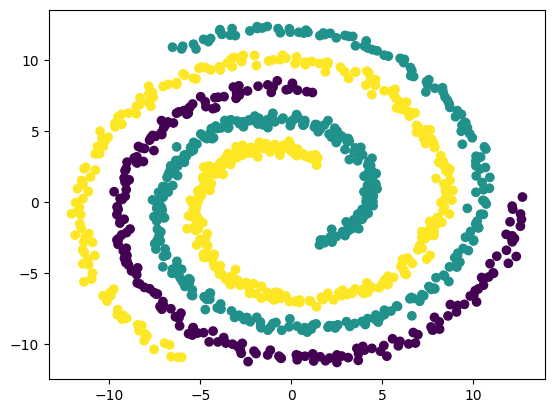

In [12]:
plt.scatter(X[:,0], X[:,1], c=y_true)

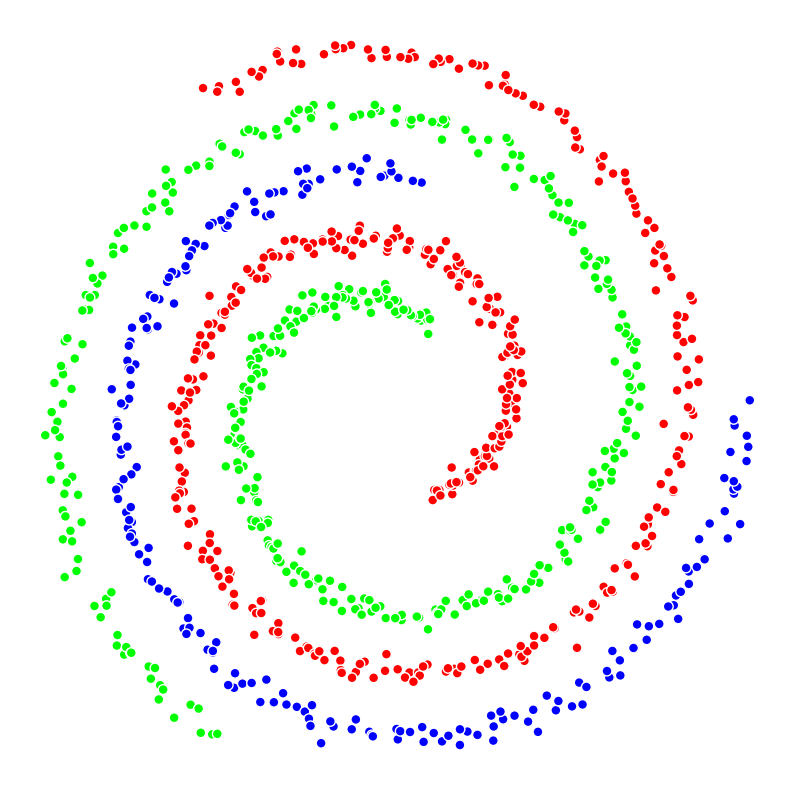

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.gca()

# 5. Scatter Points
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y_true,
      cmap="brg",
    s=50,
    edgecolors="white",
    zorder=10,
)

# plt.title(
#     rf"Edges with $W_{{ij}} > {threshold}$, thickness $\propto W_{{ij}}$",
#     fontdict={'fontsize': 14}
# )
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.axis("equal")  # Important to keep the circular shape of the helix
# plt.grid(True, alpha=0.3)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.set_axis_off()
plt.savefig("figures/3_helices_true.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [14]:
threshold = 0.5
rows, cols = np.where(np.triu(W, 1) > threshold)
lines = []
widths = []
colors = []

for r, c in zip(rows, cols):

    lines.append([X[r], X[c]])
    widths.append(W[r, c] * 2.0)
    
    if y_true[r] == y_true[c]:
        colors.append((0, 0, 0, 0.3))
    else:
        colors.append((1, 0, 0, 0.6))


lines.append([[9,13],[10,13]])
widths.append( 2.0)
colors.append((0, 0, 0, 0.3))

lines.append([[9,12],[10,12]])
widths.append( 1.0)
colors.append((1, 0, 0, 0.6))

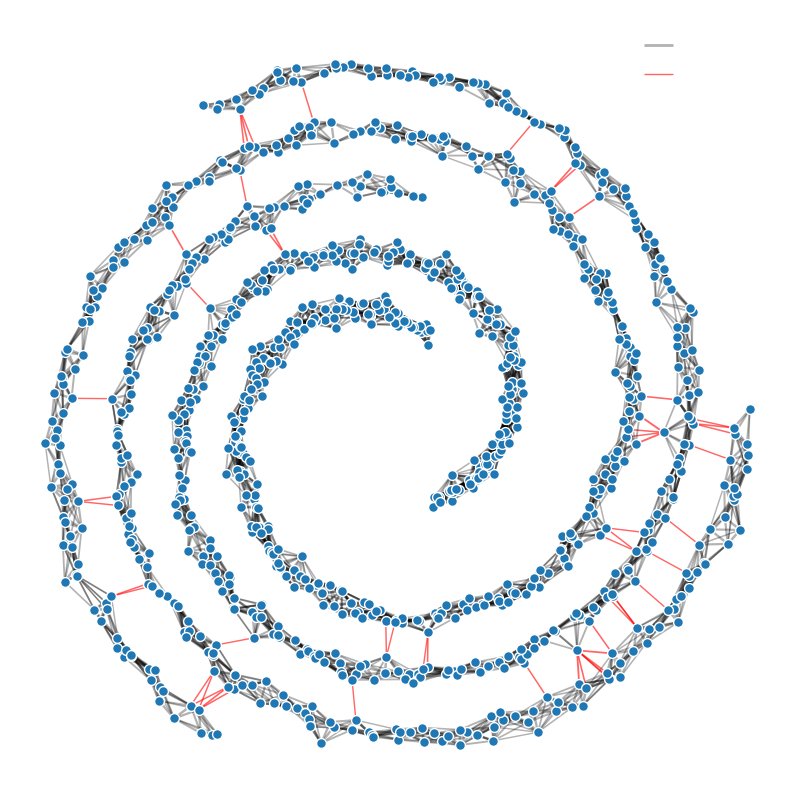

In [15]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
lc = LineCollection(lines, linewidths=widths, colors=colors)
ax.add_collection(lc)

scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    s=50,
    edgecolors="white",
    zorder=10,
)

ax.set_axis_off()

plt.savefig("figures/3_helices_graph.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [16]:
def simulation_assignment(P):

    n,k = P.shape

    rng = np.random.rand(n,1)
    cumsum = np.cumsum(P, axis=1)

    z = np.eye(k)[(rng < cumsum).argmax(axis=1)]

    return z

In [17]:
def compute_rcut(W, D, A):
    B = 1 - A
    vol = A.sum(axis=0)
    return np.diag(B.T @ (W @ A)) / vol

def compute_ncut(W, D, A):
    B = 1 - A
    vol = (A.T @ D)
    return np.diag(B.T @ (W @ A)) / vol

In [18]:
def monte_carlo_expected_cut(P, W, D, n_samples, cut_type):
    estimate = 0.0
    std = 0.0

    for _ in range(n_samples):
        A = simulation_assignment(P)
        if cut_type == "rcut":
            cut = compute_rcut(W,D, A)
        elif cut_type == "ncut":
            cut = compute_ncut(W,D, A)
        else:
            raise ValueError(f"cut_type {cut_type} not supported")
        estimate += cut
        std += cut**2

    estimate /= n_samples
    std /= n_samples
        
    return estimate, (std - estimate **2)**0.5

In [19]:
mc_means = []
mc_stds = []

for i, tau in enumerate(temperatures):
    P = softmax(logits / tau, axis=1)

    mc_val, mc_std = monte_carlo_expected_cut(P, W, D, MC_NUM_SAMPLES, cut_type="rcut")

    mc_means.append(mc_val)
    mc_stds.append(mc_std)

    print(f"tau_{i}={tau:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


tau_0=0.0010  |  11.3175  |  0.0112  
tau_1=0.0013  |  11.3179  |  0.0122  
tau_2=0.0016  |  11.3184  |  0.0133  
tau_3=0.0020  |  11.3189  |  0.0147  
tau_4=0.0026  |  11.3192  |  0.0162  
tau_5=0.0032  |  11.3193  |  0.0179  
tau_6=0.0041  |  11.3194  |  0.0202  
tau_7=0.0052  |  11.3193  |  0.0229  
tau_8=0.0066  |  11.3196  |  0.0267  
tau_9=0.0083  |  11.3202  |  0.0308  
tau_10=0.0105  |  11.3204  |  0.0356  
tau_11=0.0133  |  11.3209  |  0.0413  
tau_12=0.0168  |  11.3212  |  0.0459  
tau_13=0.0212  |  11.3202  |  0.0507  
tau_14=0.0268  |  11.3192  |  0.0561  
tau_15=0.0339  |  11.3184  |  0.0624  
tau_16=0.0429  |  11.3167  |  0.0690  
tau_17=0.0543  |  11.3147  |  0.0771  
tau_18=0.0687  |  11.3134  |  0.0852  
tau_19=0.0869  |  11.3110  |  0.0963  
tau_20=0.1099  |  11.3091  |  0.1072  
tau_21=0.1389  |  11.3071  |  0.1198  
tau_22=0.1758  |  11.3048  |  0.1322  
tau_23=0.2223  |  11.3013  |  0.1476  
tau_24=0.2812  |  11.2960  |  0.1637  
tau_25=0.3556  |  11.2884  |  0.181

In [20]:
mc_m = np.array(mc_means)
mc_s = np.array(mc_stds)

In [21]:
np.save("./buckets/checkpoints/hycut_mc_mean.npy", mc_m)
np.save("./buckets/checkpoints/hycut_mc_std.npy", mc_s)
np.save("./buckets/checkpoints/hycut_mc_tau.npy", temperatures)

In [22]:
mc_m = np.load("./buckets/checkpoints/hycut_mc_mean.npy")
mc_s = np.load("./buckets/checkpoints/hycut_mc_std.npy")

In [23]:
mc_m.shape, mc_s.shape

((50, 3), (50, 3))

In [46]:
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['font.serif'] = ['DejaVu Sans']

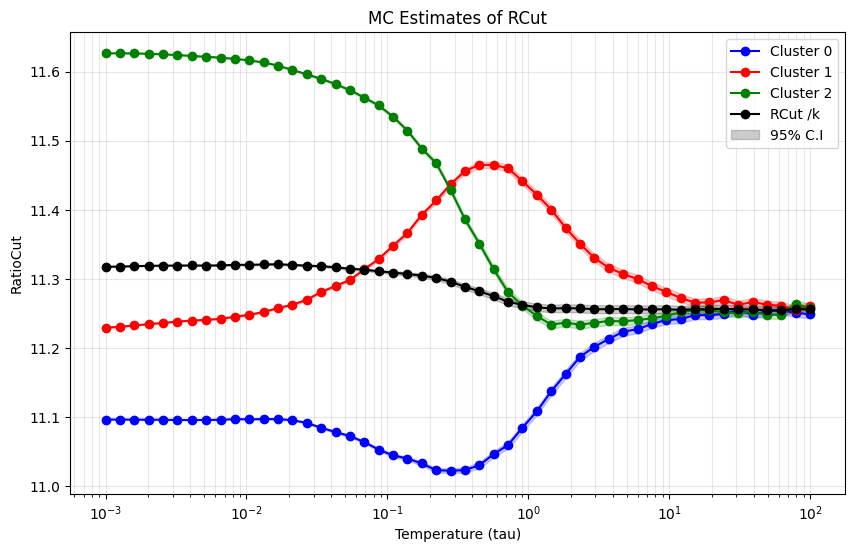

In [ ]:
plt.figure(figsize=(10, 6))
    
k = 0
for k,c in zip(range(3), ["blue", "red", "green"]):
    plt.plot(temperatures, mc_m[:,k], 'o-', label=f'Cluster {k}', color=c)

    plt.fill_between(temperatures,
                    mc_m[:,k] - 1.96*mc_s[:,k]/MC_NUM_SAMPLES**.5,
                    mc_m[:,k] + 1.96*mc_s[:,k]/MC_NUM_SAMPLES**.5, 
                    color=c,
                    alpha=0.2,
                    # label='95% C.I'
                    )
c = "black"

plt.plot(temperatures, mc_m.mean(1), 'o-', label='Average', color=c)

plt.fill_between(temperatures,
                mc_m.mean(1) - 1.96*(mc_s**2).mean(1)**0.5 / MC_NUM_SAMPLES**.5,
                mc_m.mean(1) + 1.96*(mc_s**2).mean(1)**0.5 /MC_NUM_SAMPLES**.5, 
                color=c,
                alpha=0.2,
                label='95% C.I')

# plt.plot(temperatures, bound_vals, 's--', label='Paper Bound (Upper)', color='red')

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel(r'Temperature $\tau$')
plt.ylabel('RCut')
plt.title(r'Monte-Carlo Estimation of RCut')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.savefig("figures/mc_rcut.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [59]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(X.shape[0]-2)
b = 1.
c = 2.

estimate = []
prcut_estimate= []
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    omega = P.sum(0)
    alpha_bar = (P**2 /omega[None,1]).sum(0)
    var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    # w_p = -np.diag(P.T@(W@np.log(1e-6+P)))
    # prcut_estimate.append(np.sum(w_p / P.sum(0))/2)
    prcut_estimate.append(w_p / P.sum(0))
    # estimate.append(np.sum(w_p * sp_hyp2f1(a,b,c, P.mean(0)) )/2)
    estimate.append(w_p * sp_hyp2f1(a,b,c, P.mean(0)))
    vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

estimate = np.array(estimate)
prcut_estimate = np.array(prcut_estimate)

In [60]:
linear_t = np.linspace(0,1, 64)

In [61]:
true_P = np.eye(K)[y_true]

In [ ]:
t_mc_means = []
t_mc_stds = []


for t in linear_t:
    P = (1-t) * softmax(logits, axis=1) + t * true_P
    mc_val, mc_std = monte_carlo_expected_cut(P, W, D, MC_NUM_SAMPLES, cut_type="rcut")

    t_mc_means.append(mc_val)
    t_mc_stds.append(mc_std)

    print(f"{t:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


0.0000  |  11.2606  |  0.2420  
0.0159  |  11.2570  |  0.2431  
0.0317  |  11.2514  |  0.2457  
0.0476  |  11.2416  |  0.2448  
0.0635  |  11.2281  |  0.2468  
0.0794  |  11.2112  |  0.2494  
0.0952  |  11.1905  |  0.2506  
0.1111  |  11.1672  |  0.2539  
0.1270  |  11.1369  |  0.2553  
0.1429  |  11.1052  |  0.2553  
0.1587  |  11.0690  |  0.2603  
0.1746  |  11.0326  |  0.2605  
0.1905  |  10.9879  |  0.2635  
0.2063  |  10.9439  |  0.2653  
0.2222  |  10.8941  |  0.2656  
0.2381  |  10.8396  |  0.2690  
0.2540  |  10.7848  |  0.2705  
0.2698  |  10.7210  |  0.2720  
0.2857  |  10.6585  |  0.2777  
0.3016  |  10.5916  |  0.2767  
0.3175  |  10.5213  |  0.2806  
0.3333  |  10.4450  |  0.2815  
0.3492  |  10.3649  |  0.2854  
0.3651  |  10.2846  |  0.2876  
0.3810  |  10.1968  |  0.2919  
0.3968  |  10.1071  |  0.2898  
0.4127  |  10.0129  |  0.2916  
0.4286  |  9.9178  |  0.2941  
0.4444  |  9.8186  |  0.2965  
0.4603  |  9.7160  |  0.2972  
0.4762  |  9.6071  |  0.2998  
0.4921  |  9

In [58]:
t_mc_m = np.array(t_mc_means)
t_mc_s = np.array(t_mc_stds)

NameError: name 't_mc_means' is not defined

In [161]:
np.save("./buckets/checkpoints/hycut_t_mc_mean.npy", t_mc_m)
np.save("./buckets/checkpoints/hycut_t_mc_std.npy", t_mc_s)
np.save("./buckets/checkpoints/hycut_mc_t.npy", linear_t)

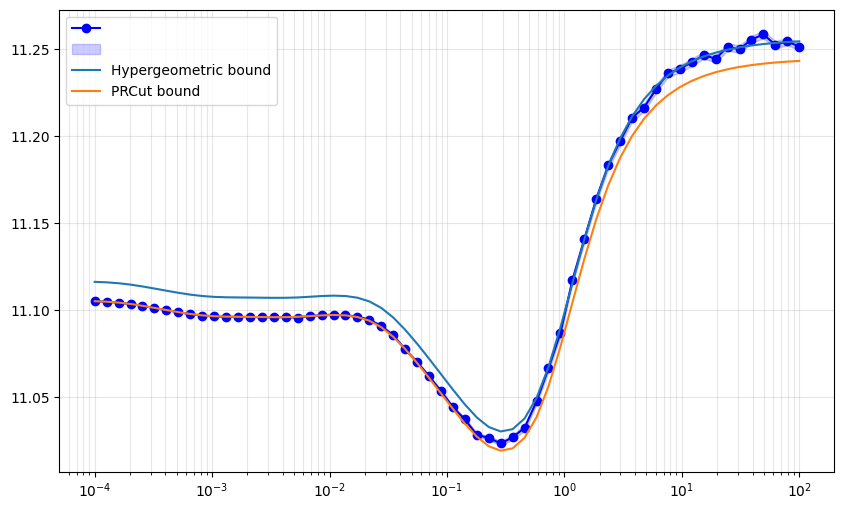

In [162]:
plt.figure(figsize=(10, 6))
k = 0
plt.plot(temperatures, mc_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures, mc_m[:,k] - mc_s[:,k]/MC_NUM_SAMPLES**.5, mc_m[:,k] + mc_s[:,k]/MC_NUM_SAMPLES**.5, 
                    color='blue', alpha=0.2, label=' '*8)



plt.plot(temperatures, estimate[:,k], label="Hypergeometric bound")

plt.plot(temperatures, prcut_estimate[:,k], label="PRCut bound")

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [163]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(X.shape[0]-2)
b = 1.
c = 2.

t_estimate = []
t_prcut_estimate= []
vs = []
for t in linear_t:
    P = (1-t) * softmax(logits/10.0, axis=1) + t * true_P
    omega = P.sum(0)
    alpha_bar = (P**2 /omega[None,1]).sum(0)
    var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    # w_p = -np.diag(P.T@(W@np.log(1e-6+P)))
    # prcut_estimate.append(np.sum(w_p / P.sum(0))/2)
    t_prcut_estimate.append(w_p / P.sum(0))
    # estimate.append(np.sum(w_p * sp_hyp2f1(a,b,c, P.mean(0)) )/2)
    t_estimate.append(w_p * sp_hyp2f1(a,b,c, P.mean(0)))
    vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

t_estimate = np.array(t_estimate)
t_prcut_estimate = np.array(t_prcut_estimate)

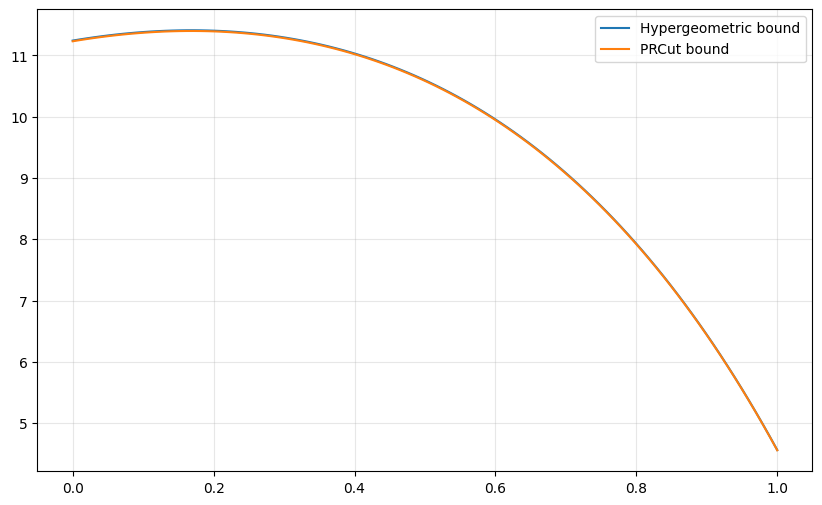

In [174]:
plt.figure(figsize=(10, 6))
k = 0

plt.plot(linear_t, t_estimate[:,k], label="Hypergeometric bound")

plt.plot(linear_t, t_prcut_estimate[:,k], label="PRCut bound")


plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

/tmp/ipykernel_172287/1645535779.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


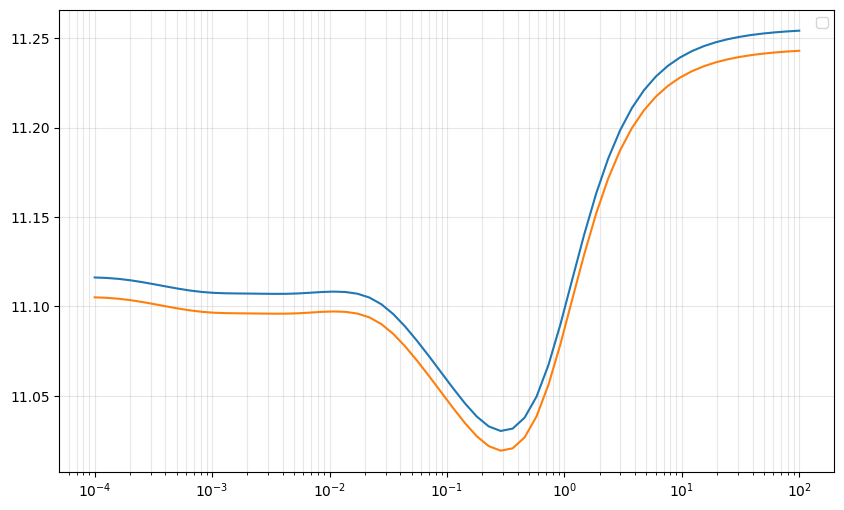

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, estimate[:,k])
plt.plot(temperatures, prcut_estimate[:,k])
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

/tmp/ipykernel_172287/1368385446.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


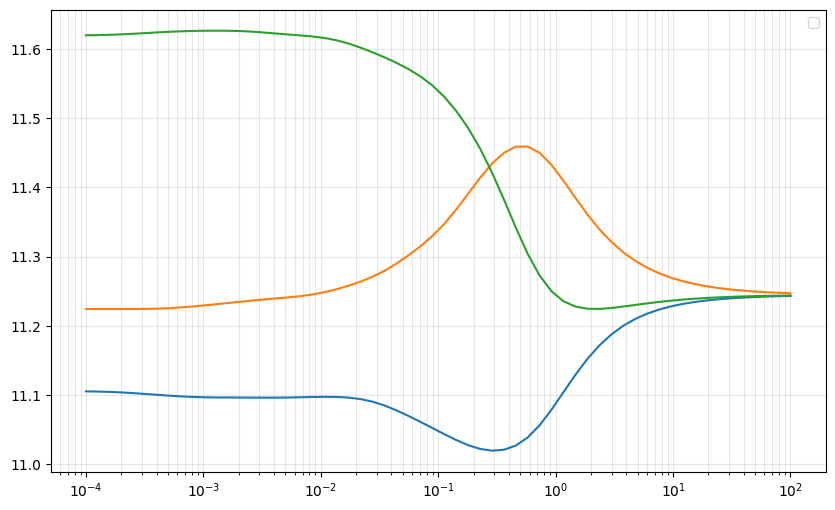

In [166]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, prcut_estimate)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [138]:
def get_safe_zero_aware_variance(P):
    """
    Computes Var_omega(alpha) safely.
    Weights w_i = p_i(1-p_i).
    """
    # 1. Weights: Zero-aware (vanish at 0 and 1)
    W_weights = P * (1.0 - P) # (N, K)
    
    # 2. Sum of weights (Omega)
    Omega = np.sum(W_weights, axis=0) # (K,)
    
    # 3. Handle collapsed weights (Hard assignments)
    # If Omega is tiny, variance is effectively 0.
    valid_mask = Omega > 1e-9
    
    # 4. Weighted Mean: Sum(w * p) / Sum(w)
    # Note: p is P itself.
    weighted_mean = np.zeros_like(Omega)
    num_mean = np.sum(W_weights * P, axis=0)
    weighted_mean[valid_mask] = num_mean[valid_mask] / Omega[valid_mask]
    
    # 5. Weighted Variance: Sum(w * (p - mu)^2) / Sum(w)
    # Broadcast weighted_mean correctly (1, K)
    diff = P - weighted_mean.reshape(1, -1)
    num_var = np.sum(W_weights * (diff**2), axis=0)
    
    weighted_var = np.zeros_like(Omega)
    weighted_var[valid_mask] = num_var[valid_mask] / Omega[valid_mask]
    
    return weighted_var, valid_mask

ValueError: x and y must have same first dimension, but have shapes (60,) and (100,)

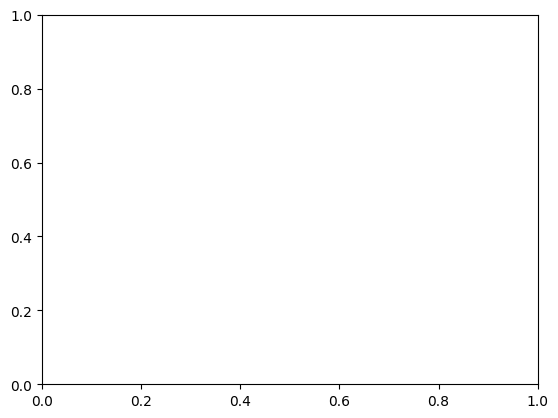

In [167]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [140]:
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    vs.append(get_safe_zero_aware_variance(P)[0].sum())

ValueError: x and y must have same first dimension, but have shapes (60,) and (100,)

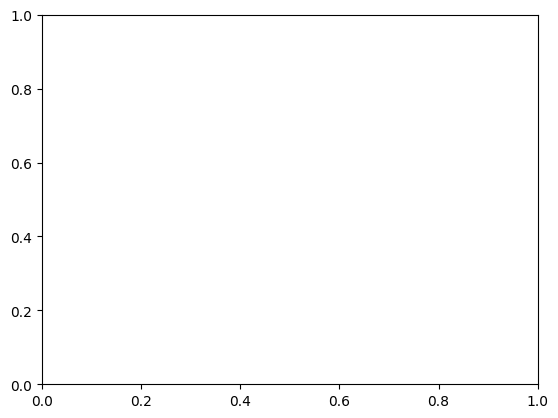

In [168]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

(array([  1.,   2.,   3.,   1.,   5.,   1.,   5.,   7.,  22.,  32.,  35.,
         44.,  64.,  55.,  67.,  72.,  84.,  78.,  96., 115.,  70.,  18.,
         23.,  19.,  12.,   9.,   5.,  12.,  10.,  16.,   8.,   9.]),
 array([ 7.74823582,  8.28626231,  8.82428879,  9.36231528,  9.90034176,
        10.43836825, 10.97639473, 11.51442122, 12.0524477 , 12.59047419,
        13.12850067, 13.66652716, 14.20455364, 14.74258013, 15.28060661,
        15.8186331 , 16.35665958, 16.89468607, 17.43271255, 17.97073904,
        18.50876552, 19.04679201, 19.58481849, 20.12284498, 20.66087146,
        21.19889795, 21.73692443, 22.27495092, 22.8129774 , 23.35100389,
        23.88903037, 24.42705686, 24.96508334]),
 <BarContainer object of 32 artists>)

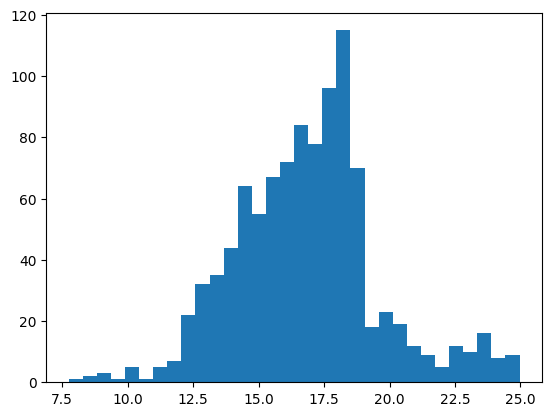

In [169]:
plt.hist(D,bins=32)

In [170]:
mc_n_means = []
mc_n_stds = []

for tau in temperatures:
    P = softmax(logits / tau, axis=1)

    mc_val, mc_std = monte_carlo_expected_cut(P, W, D, MC_NUM_SAMPLES, cut_type="ncut")

    mc_n_means.append(mc_val)
    mc_n_stds.append(mc_std)

    print(f"{tau:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


0.0001  |  0.6709  |  0.0001  
0.0001  |  0.6709  |  0.0001  
0.0002  |  0.6709  |  0.0001  
0.0002  |  0.6709  |  0.0002  
0.0003  |  0.6709  |  0.0003  
0.0003  |  0.6709  |  0.0003  
0.0004  |  0.6709  |  0.0004  
0.0005  |  0.6709  |  0.0004  
0.0007  |  0.6709  |  0.0005  
0.0008  |  0.6709  |  0.0005  
0.0010  |  0.6709  |  0.0006  
0.0013  |  0.6710  |  0.0006  
0.0017  |  0.6710  |  0.0007  
0.0021  |  0.6710  |  0.0008  
0.0027  |  0.6710  |  0.0009  
0.0034  |  0.6710  |  0.0011  
0.0042  |  0.6711  |  0.0012  
0.0054  |  0.6711  |  0.0014  
0.0068  |  0.6711  |  0.0017  
0.0086  |  0.6711  |  0.0020  
0.0108  |  0.6711  |  0.0023  
0.0137  |  0.6712  |  0.0026  
0.0173  |  0.6711  |  0.0029  
0.0218  |  0.6711  |  0.0032  
0.0276  |  0.6710  |  0.0035  
0.0349  |  0.6709  |  0.0039  
0.0441  |  0.6709  |  0.0043  
0.0557  |  0.6707  |  0.0047  
0.0704  |  0.6706  |  0.0053  
0.0890  |  0.6705  |  0.0058  
0.1124  |  0.6703  |  0.0065  
0.1421  |  0.6702  |  0.0072  
0.1796  

In [175]:
mc_n_m = np.array(mc_n_means)
mc_n_s = np.array(mc_n_stds)

In [176]:
np.save("./buckets/checkpoints/hycut_mc_n_mean.npy", mc_n_m)
np.save("./buckets/checkpoints/hycut_mc_n_std.npy", mc_n_s)
np.save("./buckets/checkpoints/hycut_mc_n_tau.npy", temperatures)

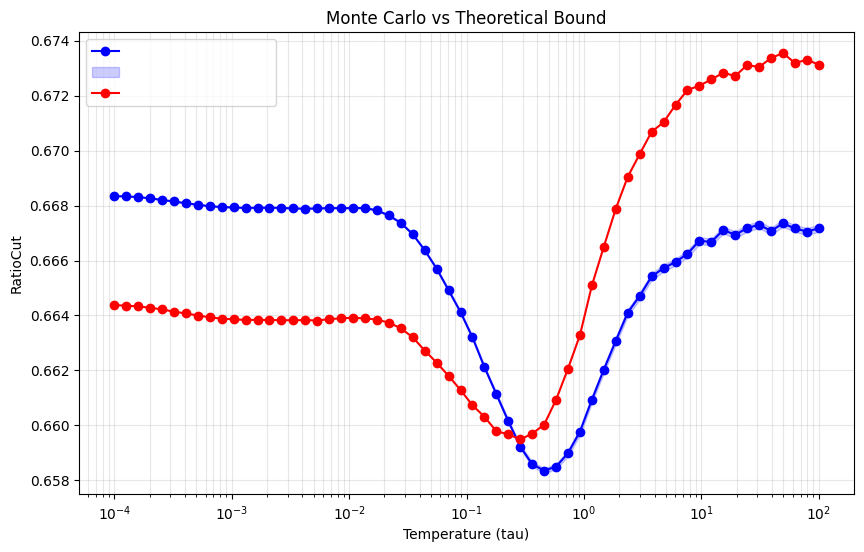

In [178]:
plt.figure(figsize=(10, 6))
    
k = 0

plt.plot(temperatures, mc_n_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures,
                mc_n_m[:,k] - mc_n_s[:,k]/MC_NUM_SAMPLES**.5,
                mc_n_m[:,k] + mc_n_s[:,k]/MC_NUM_SAMPLES**.5, 
                color='blue',
                alpha=0.2,
                label=' '*8)



plt.plot(temperatures,
        mc_m[:,k]/ mc_m[:,k].mean() * mc_n_m[:,k].mean(),
        'o-',
        label='    '*8,
        color='red')



# plt.plot(temperatures, bound_vals, 's--', label='Paper Bound (Upper)', color='red')

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel('Temperature (tau)')
plt.ylabel('RatioCut')
plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [182]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(X.shape[0]-2)
b = 1.
c = 2.

n_estimate = []
vs = []
for tau in temperatures:
    P = softmax(logits/tau, axis=1)
    # omega = P.sum(0)
    # alpha_bar = (P**2 /omega[None,1]).sum(0)
    # var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    n_estimate.append(w_p / (P.T@D))
    # vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

n_estimate = np.array(n_estimate)

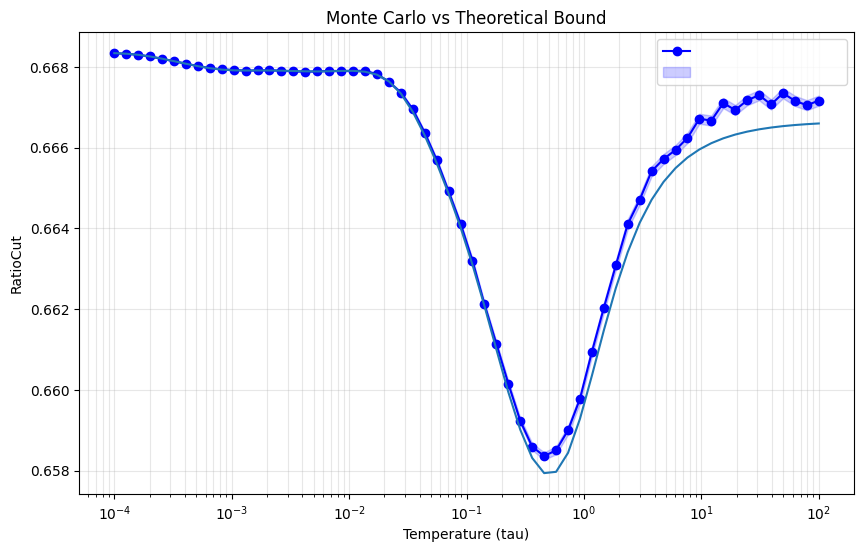

In [ ]:
plt.figure(figsize=(10, 6))
    
k = 0

plt.plot(temperatures, mc_n_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures,
                mc_n_m[:,k] - mc_n_s[:,k]/MC_NUM_SAMPLES**.5,
                mc_n_m[:,k] + mc_n_s[:,k]/MC_NUM_SAMPLES**.5, 
                color='blue',
                alpha=0.2,
                label=' '*8)


plt.plot(temperatures, n_estimate[:,k])

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel('Temperature (tau)')
plt.ylabel('RatioCut')
plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)

In [ ]:
def compute_theoretical_bound(P, W, s_type="ratio"):

    
    n, k = P.shape
    m = n - 2  # As per definition in paper for GPB
    # 1. Compute M_{il}: The 'numerator' part (expected cut edges)
    # This is efficiently calculated via matrix operations.
    # M_il = (W * P_other)_il * P_il ??? No.
    # M_{il} = sum_j W_{ij} P_{il} (1 - P_{jl})
    #        = P_{il} * sum_j W_{ij} (1 - P_{jl})

    # Probability that neighbor j is NOT in cluster l
    P_complement = 1.0 - P

    # Weighted sum of neighbors not in cluster l
    W_dot_P_comp = W @ P_complement

    # M matrix: [N x K]
    M = P * W_dot_P_comp

    # 2. Compute Phi_l(s_i): The 'denominator' bound
    # For RatioCut, s_i = 1 for all i. q = 1. beta = 1.
    # The bound depends on the Mean Assignment alpha_bar for cluster l.

    bound_val = 0.0

    if s_type == "ratio":
        # Calculate mean assignment prob for each cluster: alpha_bar_l
        # The paper defines alpha_bar over the 'other' nodes, but for large N,
        # 1/m * Sum_{all} P_il is the standard approximation.
        alpha_bar = np.mean(P, axis=0)  # [K]

        for l in range(K):
            # Compute H function for this cluster's occupancy
            # For RatioCut: q=1, beta=1
            H_val = horner_hypergeometric_ratio_cut(
                m, alpha_bar[l], q=1, beta=1
            )

            # Sum over all nodes i
            # For RatioCut, Phi is constant for all i in cluster l (since s_i=1)
            # contribution = Sum_i M_{il} * H_val

            cut_mass_l = np.sum(M[:, l])
            bound_val += cut_mass_l * H_val

    return 0.5 * bound_val  # GraphCut is 1/2 sum VolCut

Generating 3 Helices (N=1200)...
Computing Affinity Matrix (RBF)...
Temp       | MC (True)       | Bound (Ours)   
---------------------------------------------
10.0000     | 0.0000          | -1601064592320792579070597133588087221287233919164287190688113014957859673203058549214815591897718636642608052978182674242941461383348224.0000
7.8476     | 0.0000          | 221218349202363235048523342188563944201723652091920998363657418423574725917753215827046772934859446596336214513940900004739601636786176.0000
6.1585     | 0.0000          | -536788184523569464012291913551381604409695480961504950661752674289011506527994381446670239846749204718061149942521908097083722073899008.0000
4.8329     | 0.0000          | -1976789401995814485753204308151931707485213849165555512277294350070876616798673265359564308822454173847395595775482753906682281125216256.0000
3.7927     | 0.0000          | 379370949712209805598713547374287307116914459174095116344559421833225060937949289399935673968733573654372588804598

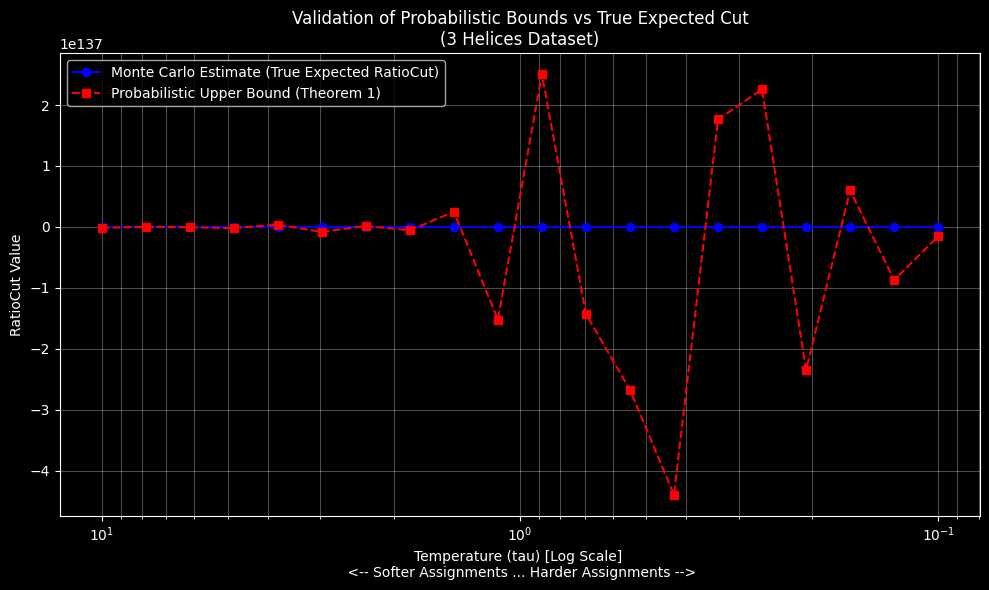

In [ ]:
run_simulation()

In [ ]:

print(f"{'Temp':<10} | {'MC (True)':<15} | {'Bound (Ours)':<15}")
print("-" * 45)